# **Evaluate Reconstruction and Simulated data**
In this notebook we will evaluate the reconstruction of the original data, as well as evaluating the predicted cell-type specific perturbation response. NOTE: only monocytes are perturbed. They are typically the largest cell-type proportions, but the perturbation is still specific to this one cell-type. This is a difficult task, because it will look like a global shift if you exclude cell-type specific information.

The data we use is the Kang data. We augment this dataset by modifying the stimulated cells. We only use stimulated monocytes in order to show the specificity in which BuDDI can work. Since the ground truth stimulation provides a global shift in expression, using only one cell type as the perturbed observation shows that BuDDI can truely identify a cell-type specific perturbation.


# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [16]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job22_Results.csv"
cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_kang/"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

batch_size = 500

exp_id = "mono-kang"



# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# number of drugs one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


# Define indices and set-up metadata

In [5]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


# compare our variable genes with cibersort defined genes

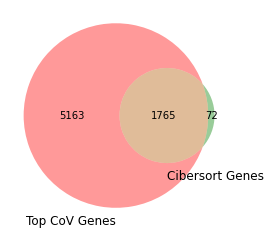

In [6]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [7]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)


# Normalize Data

In [9]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


# Plot all data

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 17320 samples in 0.082s...
[t-SNE] Computed neighbors for 17320 samples in 27.595s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17320
[t-SNE] Computed conditional probabilities for sample 2000 / 17320
[t-SNE] Computed conditional probabilities for sample 3000 / 17320
[t-SNE] Computed conditional probabilities for sample 4000 / 17320
[t-SNE] Computed conditional probabilities for sample 5000 / 17320
[t-SNE] Computed conditional probabilities for sample 6000 / 17320
[t-SNE] Computed conditional probabilities for sample 7000 / 17320
[t-SNE] Computed conditional probabilities for sample 8000 / 17320
[t-SNE] Computed conditional probabilities for sample 9000 / 17320
[t-SNE] Computed conditional probabilities for sample 10000 / 17320
[t-SNE] Computed conditional probabilities for sample 11000 / 17320
[t-SNE] Computed conditional probabilities for sample 12000 / 17320
[t-SNE] Computed conditional probabilities for sa

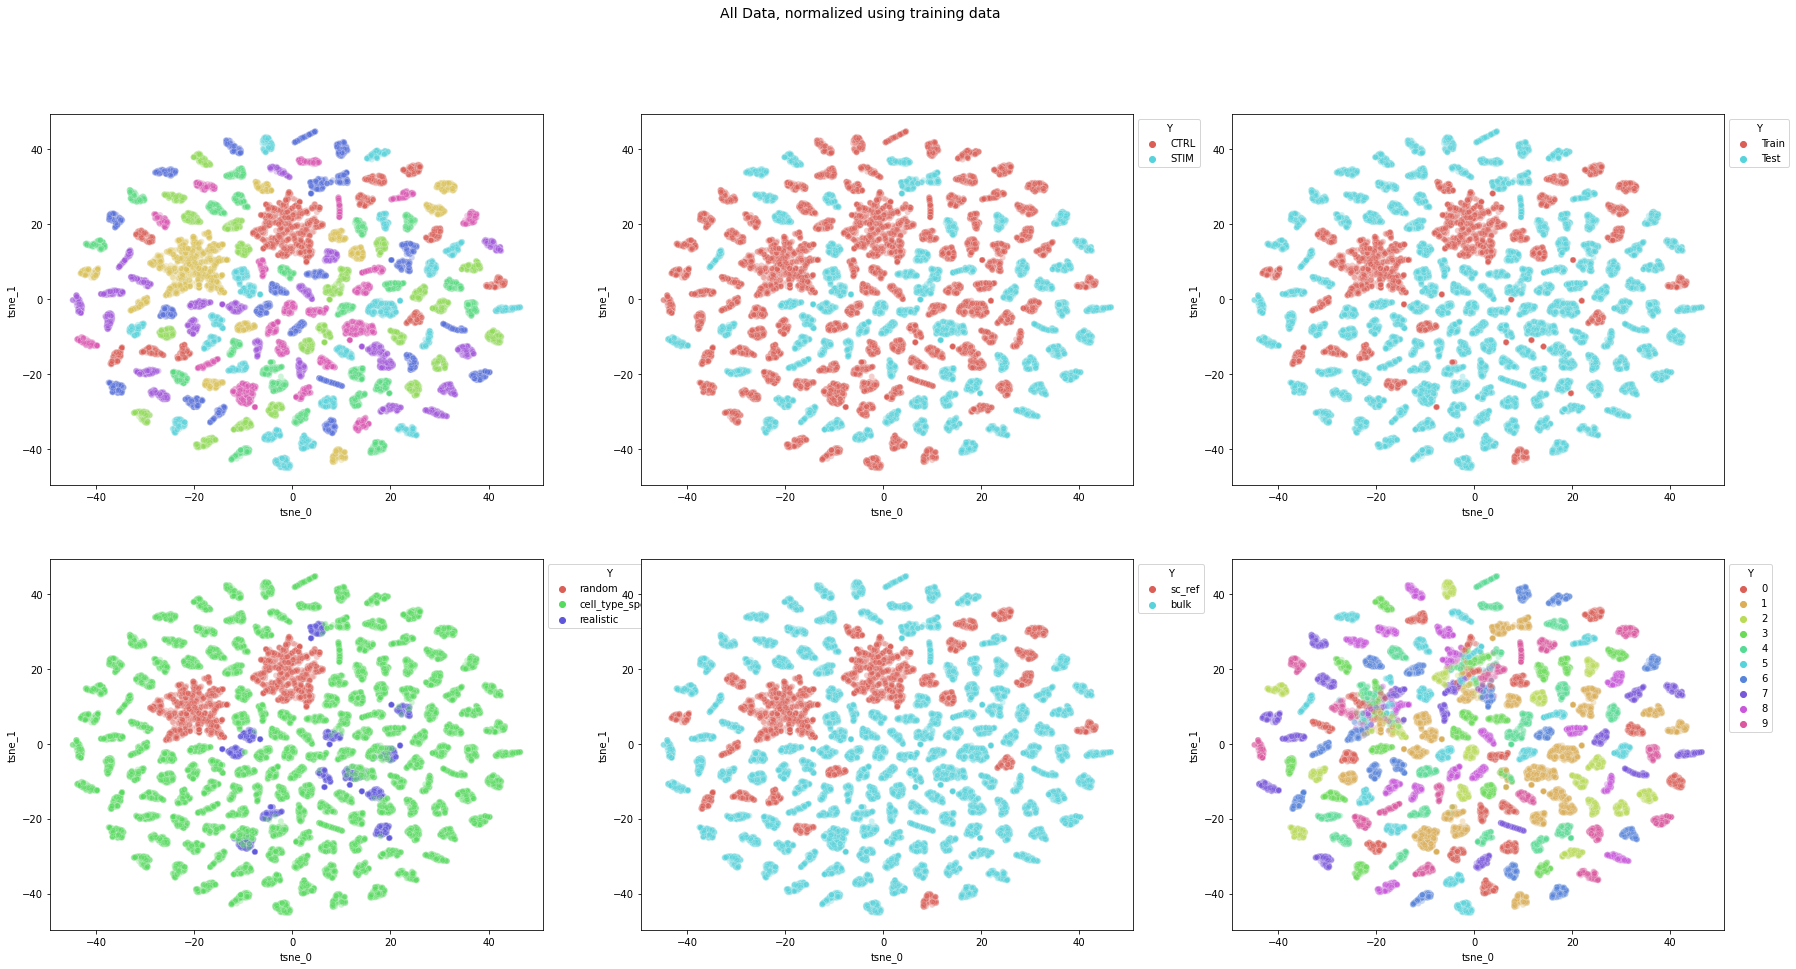

In [10]:
## plot samples
plot_df = vp.get_tsne_for_plotting(X_full)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(120, 2)
(120, 2)


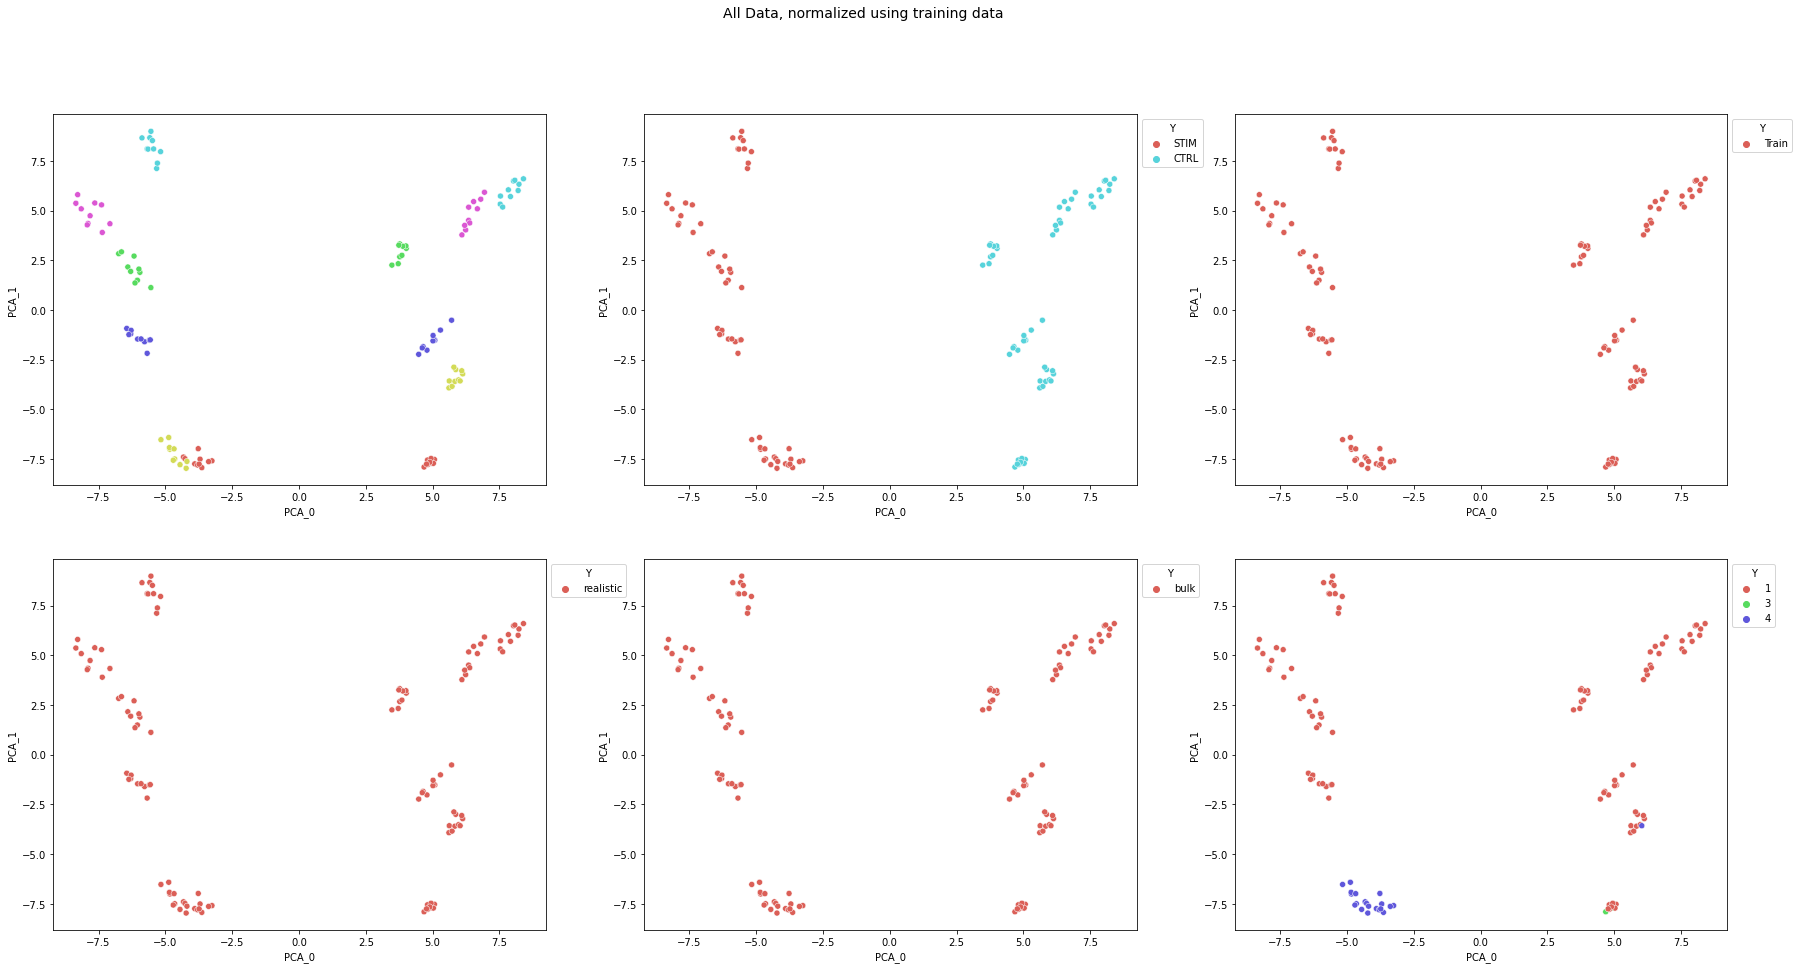

In [11]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1)
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1)
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1)


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.001s...
[t-SNE] Computed neighbors for 120 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 12.872424


[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.945129
[t-SNE] KL divergence after 500 iterations: 0.064786
(120, 2)
(120, 2)


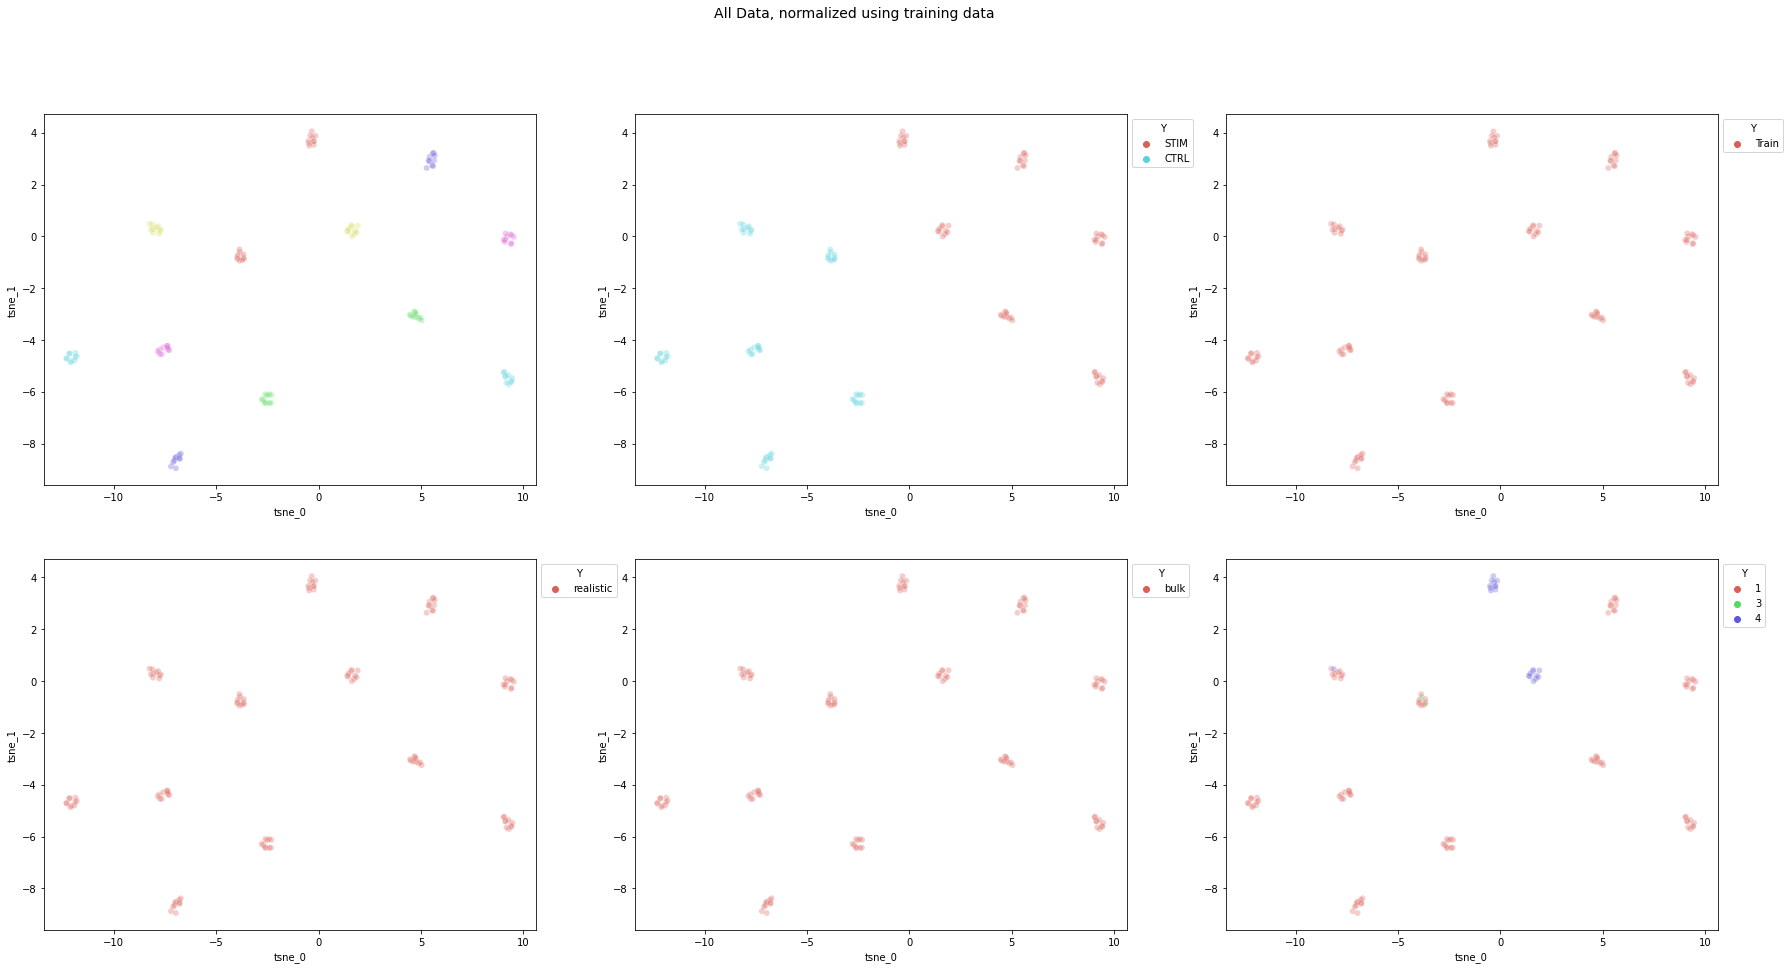

In [12]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in trained models**

In [210]:

res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/model1_{exp_id}_classifier")


# res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/buddi4_model2_{exp_id}_encoder_unlab")
# res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/buddi4_model2_{exp_id}_encoder_lab")
# res2_dec = tf.keras.models.load_model(f"{res_data_path}/buddi4_model2_{exp_id}_decoder")
# res2_classifier = tf.keras.models.load_model(f"{res_data_path}/buddi4_model2_{exp_id}_classifier")


# res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/buddi4_model3_{exp_id}_encoder_unlab")
# res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/buddi4_model3_{exp_id}_encoder_lab")
# res3_dec = tf.keras.models.load_model(f"{res_data_path}/buddi4_model3_{exp_id}_decoder")
# res3_classifier = tf.keras.models.load_model(f"{res_data_path}/buddi4_model3_{exp_id}_classifier")

# **Inspect the output**

## Plot Reconstruction

In [180]:
from importlib import reload  # Python 3.4+
reload(buddi)
reload(buddi.buddi4)
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../buddi/plotting/validation_plotting.py'>

In [194]:
# subset the data to the bulk data with realistic cell-type proportions
recon_idx = np.where(np.logical_and(meta_df.cell_prop_type == "cell_type_specific", meta_df.isTraining == "Test"))[0]
recon_idx = np.where(recon_idx)[0]
recon_idx = np.random.choice(recon_idx, 5000, replace=True)

X_temp = np.copy(X_full[recon_idx])

Y_temp = np.copy(Y_full.iloc[recon_idx])
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_full.columns[Y_temp]


label_temp = np.copy(Label_full[recon_idx])
label_temp = index_label[label_temp]

perturb_temp = Drug_full[recon_idx]

# get estimated proportions
prop_outputs = res1_classifier.predict(X_temp, batch_size=batch_size)

# now use the encoder to get the latent spaces
z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _ = res1_enc_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug, z_bulk])

# and decode
decoded_outputs = res1_dec.predict(z_concat, batch_size=batch_size)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(10000, 2)
(10000, 2)


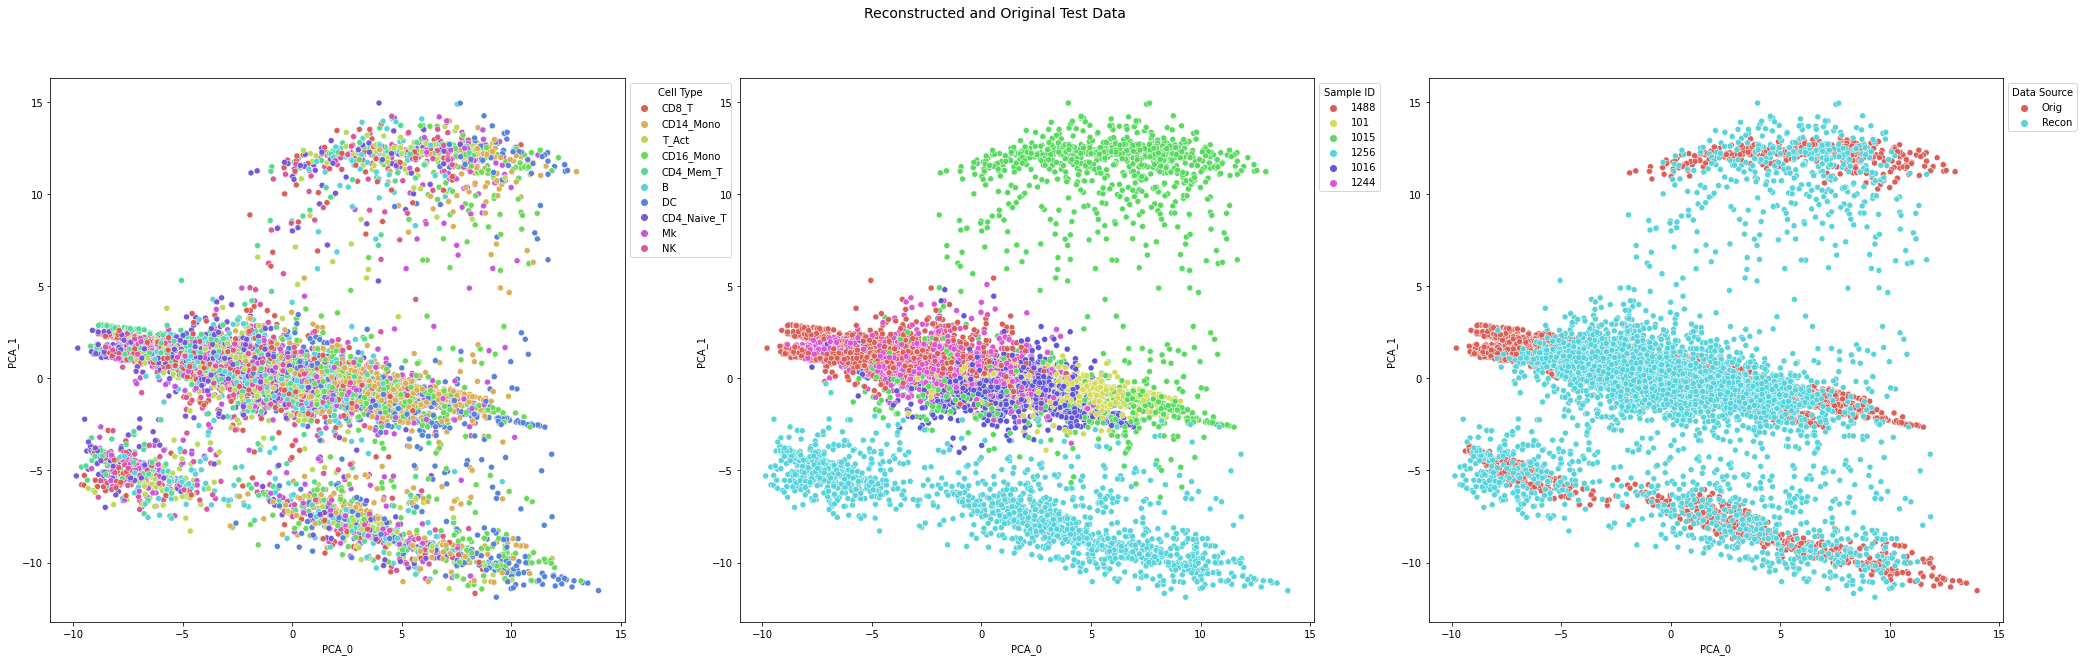

In [141]:
# make duplicated to compare
X_dup = np.vstack([X_temp, decoded_outputs])


Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*5000, [1]*5000))

source_dup_str = ["Recon" if x  else "Orig" for x in source_dup ]


fig, axs = plt.subplots(1, 3, figsize=(35,10))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="", alpha=1, legend_title="Cell Type")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, color_vec=source_dup_str, ax=axs[2], title="", alpha=1, legend_title="Data Source")


fig.suptitle("Reconstructed and Original Test Data", fontsize=14)

fig.show()

## Do latent space projections

### drug perturbation

In [205]:
res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = buddi.calc_buddi_perturbation_sample_specific(
                                                                            meta_df, X_full, Y_full, 
                                                                            ['101', '1016', '1039', '107', '1244', '1488'],
                                                                            scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../buddi/buddi.py:585: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_meta_df.isTraining = "Test"
/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/../buddi/buddi.py:586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [206]:

# run first the cell_type specific things

cell_type_specific_r2 = None
cell_type_specific_real = None
cell_type_specific_proj = None
meta_DESeq = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']



for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        real_stim, real_ctrl, proj_stim, proj_ctrl = vp.subset_sample_celltype_perturbation(X_full, res1_decoded_0_0, 
                                                                                        res1_decoded_0_1, scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, res1_meta_df,
                                                                                        curr_cell_type)

        expr_r2_stim, expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2_stim,
                     expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, 
                     log2FC_r2_top, log2FC_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2_stim', 'expr_r2_ctrl', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse'])

        curr_meta_real = {'sample_id':[curr_samp]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                        'cell_type':[curr_cell_type]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                        'cond':['ctrl']*(real_ctrl.shape[0]) + ['stim']*(real_stim.shape[0])}
        curr_meta_real = pd.DataFrame(curr_meta_real)

        curr_meta_proj = {'sample_id':[curr_samp]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                        'cell_type':[curr_cell_type]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                        'cond':['ctrl']*(proj_ctrl.shape[0]) + ['stim']*(proj_stim.shape[0])}
        curr_meta_proj = pd.DataFrame(curr_meta_proj)
        
        curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
        curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
            meta_DESeq_real = curr_meta_real
            meta_DESeq_proj = curr_meta_proj
            cell_type_specific_real = curr_DESeq_real
            cell_type_specific_proj = curr_DESeq_proj
        else:
             cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
             meta_DESeq_real = pd.concat([meta_DESeq_real, curr_meta_real])
             meta_DESeq_proj = pd.concat([meta_DESeq_proj, curr_meta_proj])
             cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
             cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)



# now run the realistic ones

101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


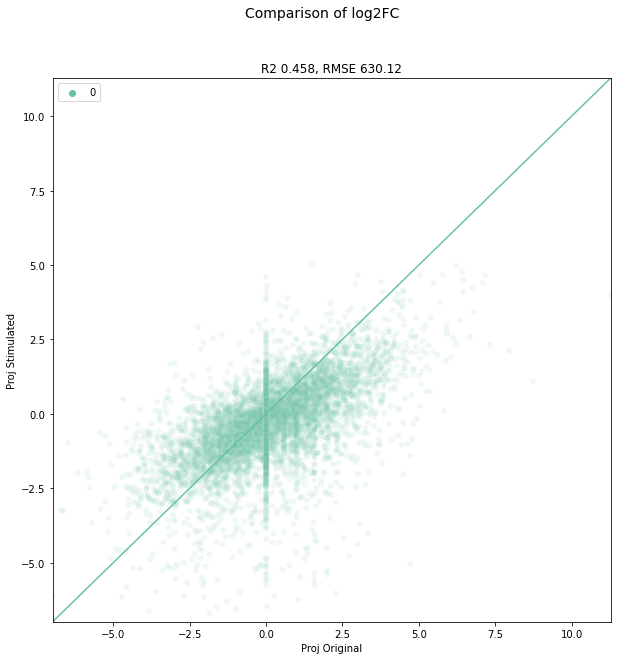

In [207]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

class_color = [0]*len(real_stim_med)


fig, axs = plt.subplots(1, 1, figsize=(10,10))

a = real_stim_med
b = proj_stim_med
nas = np.logical_or(np.isnan(a), np.isnan(b))

r2_log2FC = np.round(r2_score(a[~nas], b[~nas]), 3)
rmse_log2FC = np.round(np.sqrt(mean_squared_error(a[~nas], b[~nas])), 3)

max_val = np.max([np.max(real_log2FC), np.max(proj_log2FC)])
min_val = np.min([np.min(real_log2FC), np.min(proj_log2FC)])
vp.plot_expr_corr(real_log2FC, proj_log2FC, axs, 
                    title=f"R2 {r2_log2FC}, RMSE {rmse_log2FC}", 
                    xlab="Proj Original", ylab="Proj Stimulated", 
                    class_id=class_color, max_val=max_val, min_val=min_val, alpha=0.1)


fig.suptitle("Comparison of log2FC", fontsize=14)

fig.show()


In [208]:
cell_type_specific_r2

,sample_id,cell_type,bulk_type,expr_r2_stim,expr_r2_ctrl,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse
0,101,B,cell_type_specific,0.810525,0.820137,0.804505,0.637042,0.862543,0.886277,1.040085
0,101,CD14_Mono,cell_type_specific,0.913934,0.912847,0.690536,0.442146,0.741937,0.881420,2.069237
0,101,CD16_Mono,cell_type_specific,0.859121,0.868000,0.812082,0.621307,0.877917,0.900290,1.011173
0,101,CD4_Mem_T,cell_type_specific,0.826615,0.836468,0.816392,0.615803,0.875702,0.910078,1.021903
0,101,CD4_Naive_T,cell_type_specific,0.836206,0.842072,0.805866,0.606386,0.888198,0.881907,1.030892
0,101,CD8_T,cell_type_specific,0.812718,0.814429,0.810713,0.621106,0.895305,0.880510,1.032132
0,101,DC,cell_type_specific,0.814579,0.826113,0.793550,0.614388,0.877150,0.865834,1.037258
0,101,Mk,cell_type_specific,0.847175,0.833135,0.802875,0.613988,0.889234,0.876553,1.059686
0,101,NK,cell_type_specific,0.812959,0.808227,0.817597,0.622496,0.904457,0.887559,1.030634
0,101,T_Act,cell_type_specific,0.795919,0.809626,0.801671,0.621544,0.878647,0.859375,1.052512


In [209]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_matr.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)
